In [1]:
using Revise

In [2]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **



## Define CaOH Hamiltonian and molecular states

In [3]:
package = get_CaOH_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_CaOH_package_12_A_states(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;

## Define experimental parameters

In [4]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 100e-3 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -72; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
Δ4 = 0.0
Δ5 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2 # mW

# r1 = 3.7
# r3 = 2.8 
# r2 = 3.5

r1 = 1
r3 = 1
r2 = 0

p1 = r1/(r1+r2+r3) * power_total
p3 = r3/(r1+r2+r3) * power_total
p2 = r2/(r1+r2+r3) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 2 * p2 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 0.0
s5 = 0.0



blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 1000,
                                pol1_x=σ⁺, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant =0.22)
;

In [5]:
saving_path = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_2freq_pm_normalB_diffusion_1000_1to1.jl";

In [5]:
using Serialization
results_list = deserialize(saving_path);

In [6]:
aom1_freqs = 52.75:0.25:54.75

52.75:0.25:54.75

In [7]:
results_list = []

for aom1_freq in aom1_freqs
    @printf("AOM 1: %.2f MHz \n", aom1_freq)
    Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
    blue_MOT_params.Δ3 = Δ3
    
    ~,diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-4, n_particles=20, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=80e-6)
    blue_MOT_params.diffusion_constant = diffusion_constant
    @printf("Diffusion const = %.3f \n", diffusion_constant)
    
    sequence = [blue_MOT_params]
    durations = [15e-3]
    generate_sequence!(sequence, durations);
    results = simulate_particles_constant_diffusion(package, package_A, sequence)
    push!(results_list, results)
    
    serialize(saving_path, results_list)

    @printf("goodness = %.2f",  goodness(blue_MOT_params.t_end, results))
    
    println()
    println()
end

AOM 1: 52.75 MHz 


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


Diffusion const = 0.235 


Progress: 100%|█████████████████████████████████████████| Time: 0:17:01


Survival: 60 / 1000
goodness = 0.01

AOM 1: 53.00 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.238 


Progress: 100%|█████████████████████████████████████████| Time: 0:20:07


Survival: 102 / 1000
goodness = 0.02

AOM 1: 53.25 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.237 


Progress: 100%|█████████████████████████████████████████| Time: 0:27:00


Survival: 169 / 1000
goodness = 0.03

AOM 1: 53.50 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


Diffusion const = 0.246 


Progress: 100%|█████████████████████████████████████████| Time: 0:24:59


Survival: 169 / 1000
goodness = 0.03

AOM 1: 53.75 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


Diffusion const = 0.234 


Progress: 100%|█████████████████████████████████████████| Time: 0:21:34


Survival: 238 / 1000
goodness = 0.04

AOM 1: 54.00 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


Diffusion const = 0.234 


Progress: 100%|█████████████████████████████████████████| Time: 0:21:38                                                                                  


Survival: 254 / 1000
goodness = 0.04

AOM 1: 54.25 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


Diffusion const = 0.232 


Progress: 100%|█████████████████████████████████████████| Time: 0:22:03                                                                            


Survival: 223 / 1000
goodness = 0.03

AOM 1: 54.50 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress:   2%|█                                        |  ETA: 0:24:00

Diffusion const = 0.232 


Progress: 100%|█████████████████████████████████████████| Time: 0:20:42


Survival: 189 / 1000
goodness = 0.02

AOM 1: 54.75 MHz 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


Diffusion const = 0.233 


Progress: 100%|█████████████████████████████████████████| Time: 0:17:25


Survival: 97 / 1000
goodness = 0.01



In [9]:
sizes = Float64[]
size_errors = Float64[]
for results in results_list[1:end]
    size, error = bootstrap_size_fit(results, 15; iter=100, range=0.5, n_grids=20)
    println(size)
    push!(sizes, size)
    push!(size_errors, error)
end

signals = Float64[]
signal_errors = Float64[]

for results in results_list[1:end]
    signal, error = bootstrap_survival(results,15, iter=100,rmax=2.0)
    push!(signals, signal)
    push!(signal_errors, error)
end;

temps = Float64[]
temp_errors = Float64[]
for results in results_list[1:end]
    temp, error = bootstrap_temperature_fit(results, 10; iter=100)
    println(temp)
    push!(temps, temp)
    push!(temp_errors, error)
end

0.1610949053437432
0.15242755045133916
0.14050567557898908
0.13457718674287983
0.11336647666300155
0.1353279922059749
0.13310139889239805
0.15876274585237446
0.19647932066845228
248.00882741022266
219.02415869739335
217.22309359973616
255.12513270078927
244.01938021994837
255.87077598957868
269.331795841548
311.31046970984613
522.3841428904642


┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573


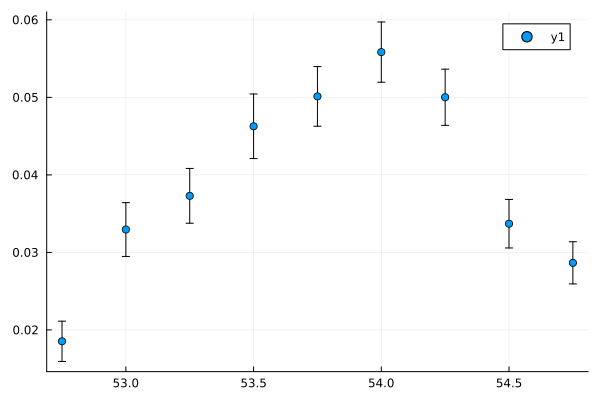

In [78]:
scatter(aom1_freqs[1:end], signals, yerr=signal_errors)

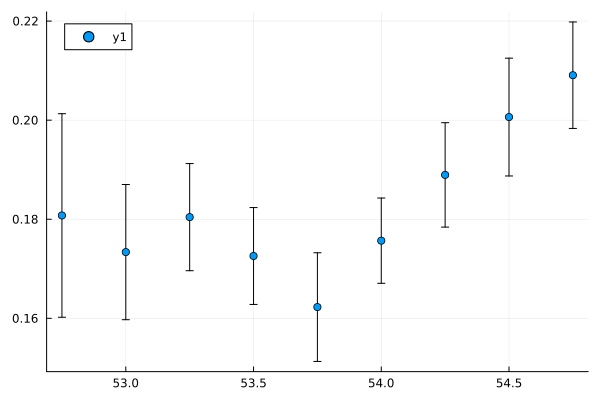

In [76]:
scatter(aom1_freqs[1:end], sizes, yerr=size_errors)

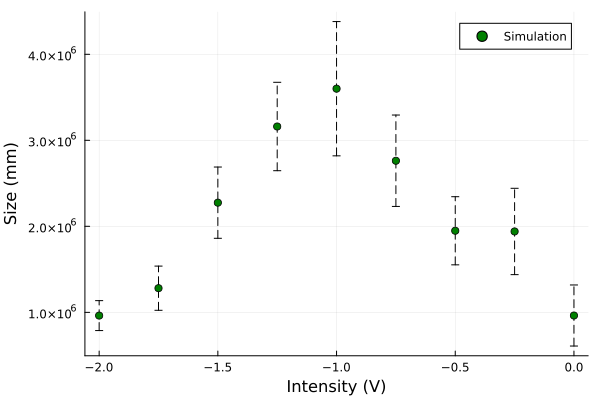

In [77]:
units = 1e3 * 2900/0.6
densities = signals./sizes.^3 * units / (2π)^(3/2)
density_errors = sqrt.((signal_errors ./ sizes.^3).^2 + (3 .* size_errors .* signals ./sizes.^4).^2) * units / (2π)^(3/2)

scatter(52.75 .- aom1_freqs[1:end],densities, yerr=density_errors ,color="green",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation",
ribbon=(size_errors, size_errors),fc=:green,fa=0.2)

plot!()

In [17]:
using MAT

simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\2freq_pm_normalB_simulations.mat";

In [5]:
close(file);

In [18]:
file = matopen(simulation_file_path, "w")
write(file, "aom1_freqs", collect(aom1_freqs[1:end-1]))

write(file, "simulation_sizes", sizes)
write(file, "simulation_size_errors", size_errors)

write(file, "simulation_signals", signals)
write(file, "simulation_signal_errors", signal_errors)

write(file, "simulation_densities", densities)
write(file, "simulation_density_errors_3", density_errors)

close(file);

In [44]:
close(file);

## Find the diffusion constant

In [86]:
diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-4, n_particles=20, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=80e-6)
@printf("Diffusion constant = %.2f \n", diffusion_constant)

blue_MOT_params.diffusion_constant = diffusion_constant;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


Diffusion constant = 1.70 


In [56]:
results = results_list[5];

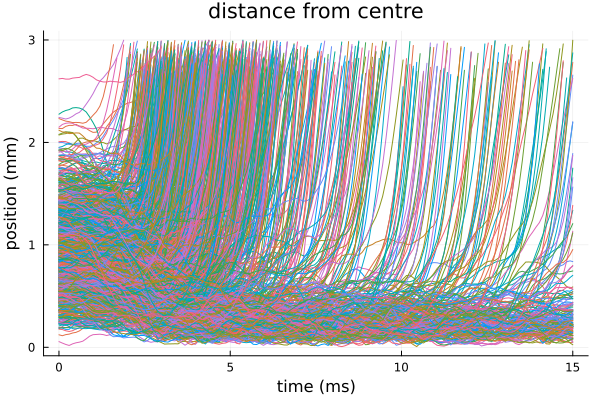

In [57]:
plot_all_trajectories(results,"all")
plot!()

In [58]:
ts = 0.1:0.5:15
sizes = Float64[]
errors = Float64[]

for t in ts
    size, error = bootstrap_size_fit(results, t; iter=100, range=0.6)
    push!(sizes, size)
    push!(errors, error)
end

numbers = Float64[]
n_errors = Float64[]
for t in ts
    n, error = bootstrap_survival(results, t, rmax=2.0)
    push!(numbers, n)
    push!(n_errors, error)
end

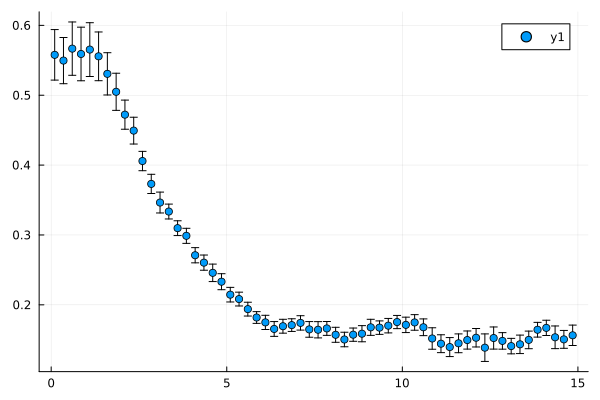

In [59]:
scatter(ts, sizes, yerr=errors)

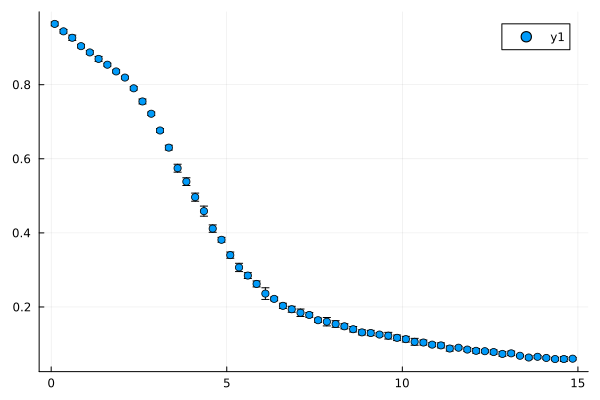

In [55]:
scatter(ts, numbers, yerr=n_errors)

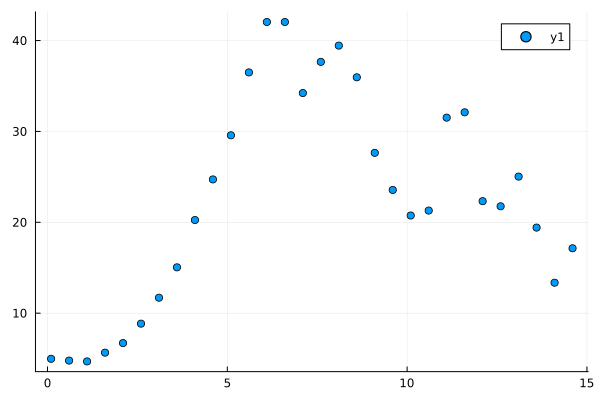

In [42]:
scatter(ts,numbers./sizes.^3)

In [61]:
bootstrap_temperature_fit(results_list[5],15;iter=100)

(178.42704957736086, 34.60476892793088)

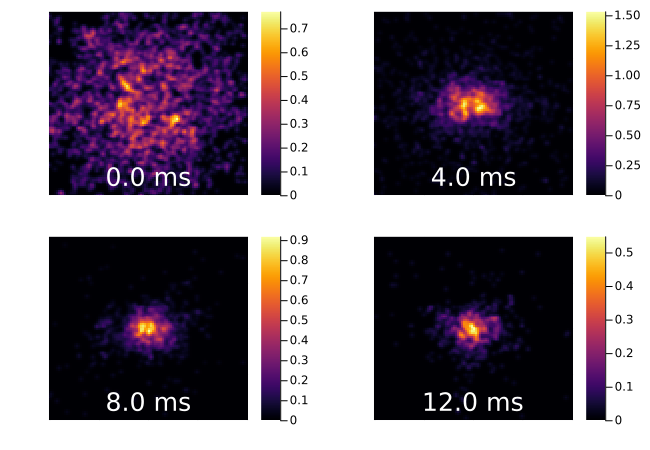

In [50]:
ROI = 1  # mm
results=results_list[5]

img_duration = 2.0   # the image will be averaged over this duration
n_pixels = 100

ts = [0.0, 4, 8, 12]
filter = 1.   # Gaussian filtering the image

plots = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.0, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg', xaxis=false, yaxis=false)
    annotate!(0,-ROI*0.8,text(@sprintf("%.1f ms", t),:white,17))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(650,450))
    
plot!()

In [13]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 100e-3 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -75; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
Δ4 = 0.0
Δ5 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2 # mW

# r1 = 3.7
# r3 = 2.8 
# r2 = 3.5

r1 = 1
r3 = 0.5
r2 = 0

p1 = r1/(r1+r2+r3) * power_total
p3 = r3/(r1+r2+r3) * power_total
p2 = r2/(r1+r2+r3) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 2 * p2 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 0.0
s5 = 0.0



blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 1000,
                                pol1_x=σ⁺, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant =0.21)
;

In [14]:
~,diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-4, n_particles=20, 
                                            ramp_time=1e-6, temp = 2e-4, diameter=200e-6);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


In [15]:
diffusion_constant

0.24373312956867932

In [19]:
blue_MOT_params.diffusion_constant = 0.25
blue_MOT_params.n_values = 100
sequence = [blue_MOT_params]
durations = [10e-3]
generate_sequence!(sequence, durations);
@time results = simulate_particles_constant_diffusion(package, package_A, sequence);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


 96.452013 seconds (185.07 k allocations: 38.089 MiB)


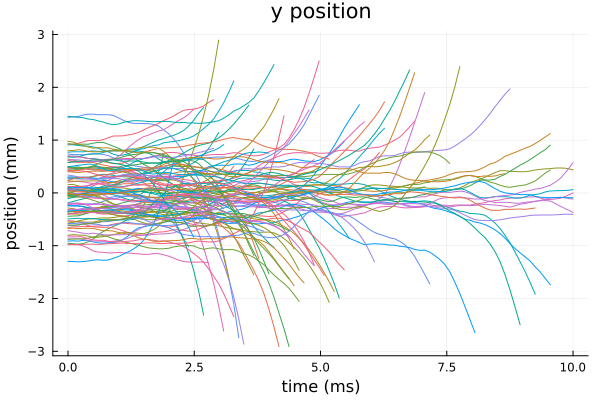

In [22]:
plot_all_trajectories(results, "y")
plot!()

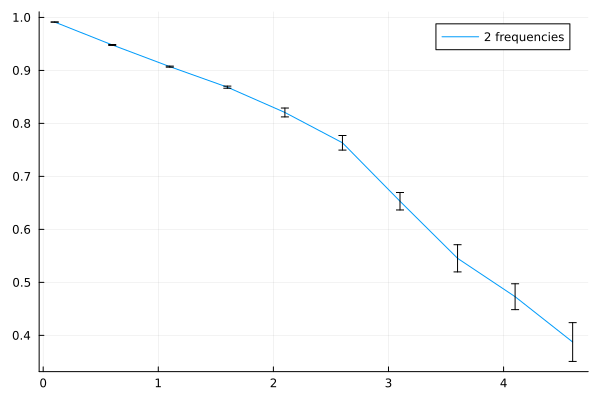

In [23]:
ts_2 = 0.1:0.5:5
numbers_2 = Float64[]
n_errors_2 = Float64[]
for t in ts_2
    n, error = bootstrap_survival(results, t, rmax=4.0)
    push!(numbers_2, n)
    push!(n_errors_2, error)
end
plot(ts_2, numbers_2, yerr=n_errors_2, label="2 frequencies")